In [4]:
import local_models.local_models
import local_models.loggin
import local_models.TLS_models
import local_models.linear_projections
import local_models.utils
import local_models.visualization
import local_models.algorithms
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import joblib
import ml_battery.log
import time
import os
from IPython.display import Markdown as md
import mayavi
import mayavi.mlab
mayavi.mlab.options.offscreen = True

logger = logging.getLogger(__name__)

reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [3]:
def import_shit():
    import local_models.local_models
    import local_models.loggin
    import local_models.TLS_models
    import local_models.linear_projections
    import local_models.utils
    import local_models.visualization
    import local_models.algorithms
    import numpy as np
    import matplotlib.pyplot as plt
    import sklearn.linear_model
    import sklearn.cluster
    from importlib import reload
    from ml_battery.utils import cmap
    import matplotlib as mpl
    import sklearn.datasets
    import sklearn.decomposition
    import logging
    import ml_battery.log
    import time
    import os
    from IPython.display import Markdown as md
    import mayavi
    import mayavi.mlab
    mayavi.mlab.options.offscreen = True


In [19]:
import os
import sys
import traceback
from functools import wraps
from multiprocessing import Process, Queue


def processify(func):
    '''Decorator to run a function as a process.
    Be sure that every argument and the return value
    is *pickable*.
    The created process is joined, so the code does not
    run in parallel.
    '''

    def process_func(q, *args, **kwargs):
        try:
            ret = func(*args, **kwargs)
        except Exception:
            ex_type, ex_value, tb = sys.exc_info()
            error = ex_type, ex_value, ''.join(traceback.format_tb(tb))
            ret = None
        else:
            error = None

        q.put((ret, error))

    # register original function with different name
    # in sys.modules so it is pickable
    process_func.__name__ = func.__name__ + 'processify_func'
    setattr(sys.modules[__name__], process_func.__name__, process_func)

    @wraps(func)
    def wrapper(*args, **kwargs):
        q = Queue()
        p = Process(target=process_func, args=[q] + list(args), kwargs=kwargs)
        p.start()
        ret, error = q.get()
        p.join()

        if error:
            ex_type, ex_value, tb_str = error
            message = '%s (in subprocess)\n%s' % (str(ex_value), tb_str)
            raise ex_type(message)

        return ret
    return wrapper

In [21]:
def hex2rgb(h):
    return tuple(int(h[i:i+2], 16)/256 for i in (0, 2 ,4))

In [22]:
def sphere(center, radius):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = radius*np.cos(u)*np.sin(v) + center[0]
    y = radius*np.sin(u)*np.sin(v) + center[1]
    z = radius*np.cos(v) + center[2]
    return x,y,z

In [28]:
DEFAULT_VIEWS = [[30,45],[30,-135],[-30,-45],[-30,135]]
def make_tlsline_kd_iterprojections_animation(linear_models, data, c, pth, bandwidth, range_pct=0.1, grid_steps=100, iterations=100, kernel=local_models.local_models.TriCubeKernel, views=DEFAULT_VIEWS):
    shifter_maker = lambda projections: local_models.algorithms.local_tls_shift(linear_models, projections, iterations=iterations, kernel=kernel(bandwidth))
    kd_3d_iterprojections_animation(shifter_maker, data, c, pth, kernel(bandwidth), range_pct=range_pct, grid_steps=grid_steps, views=views)
def make_tlsline_kd_iterprojections_animation_parallel(linear_models, data, c, pth, bandwidth, range_pct=0.1, grid_steps=100, iterations=100, kernel=local_models.local_models.TriCubeKernel, views=DEFAULT_VIEWS):
    shifter_maker = lambda projections: local_models.algorithms.local_tls_shift(linear_models, projections, iterations=iterations, kernel=kernel(bandwidth))
    kd_3d_iterprojections_animation_parallel(shifter_maker, data, c, pth, kernel(bandwidth), range_pct=range_pct, grid_steps=grid_steps, views=views)

    
def kd_3d_iterprojections_animation(shifter_maker, data, c, pth, kernel, range_pct=0.1, grid_steps=100, views=DEFAULT_VIEWS):
    from mpl_toolkits.mplot3d import axes3d
    data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(data)
    graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)

    grid = local_models.utils.get_global_grid(data, outside_range_pct=range_pct, n_steps=grid_steps)
    gridder = local_models.utils.Grid2Vec()
    projections = gridder.fit_transform(grid)
    
    kde_wireframe = local_models.utils.kernel_density(projections, noisy_circles, kernel)
    kde_wireframe = gridder.inverse_transform(kde_wireframe)[0]
    
    shifter = shifter_maker(projections)

    os.makedirs(pth, exist_ok=1)
    for i, projections in enumerate(shifter):
        fig, axes = plt.subplots(int(len(views)**0.5), int(len(views)**0.5-0.00001) + 1, subplot_kw=dict(projection='3d'), squeeze=False)
        for j in range(len(views)):
            ax = axes[int(j/axes.shape[0]), j%axes.shape[0]]
            ax.view_init(*views[j])
            ax.plot_surface(grid[0], grid[1], kde_wireframe, rstride=4, cstride=4, cmap='gray', edgecolor='k', alpha=0.7)
            data_kde = local_models.utils.kernel_density(data, data, kernel)
            for k in range(data.shape[0]):
                x,y,z = sphere([data[k:k+1,0], data[k:k+1,1], data_kde[k:k+1]]+0.1, 0.1)
                ax.plot_surface(x,y,z, color=mpl.colors.to_rgba(cmap(c[k:k+1])[0]))
            projections_kde = local_models.utils.kernel_density(projections, data, kernel)
            for m in range(projections.shape[0]):
                ax.scatter(projections[m:m+1,0], projections[m:m+1,1], projections_kde[m:m+1]+0.1, c='r', s=1)

        title = "iteration_{:05d}".format(i)
        fig.suptitle(title)
        fig.savefig(os.path.join(pth, "{}.png".format(title)))

def kd_3d_iterprojections_animation(shifter_maker, data, c, pth, kernel, range_pct=0.1, grid_steps=100, views=DEFAULT_VIEWS):
    data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(data)
    graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)

    grid = local_models.utils.get_global_grid(data, outside_range_pct=range_pct, n_steps=grid_steps)
    gridder = local_models.utils.Grid2Vec()
    projections = gridder.fit_transform(grid)
    
    kde_wireframe = local_models.utils.kernel_density(projections, noisy_circles, kernel)
    kde_wireframe = gridder.inverse_transform(kde_wireframe)[0]
    z_scale = np.max(kde_wireframe)
    
    shifter = shifter_maker(projections)

    os.makedirs(pth, exist_ok=1)
    for i, projections in enumerate(shifter):
        mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(800, 800))
        mayavi.mlab.surf(grid[0], grid[1], kde_wireframe/z_scale, colormap='Greys', opacity=1)
        data_kde = local_models.utils.kernel_density(data, data, kernel)
        colors = np.unique(c)
        for color in colors:
            mask = c == color
            data_color_masked = data[mask]
            nodes = mayavi.mlab.points3d(data_color_masked[:,0], data_color_masked[:,1], (data_kde[mask] + 0.1)/z_scale, scale_mode='scalar', color=hex2rgb(cmap([color])[0][1:]))
            nodes.mlab_source.dataset.point_data.scalars = np.ones(data_color_masked.shape[0])*0.3
        projections_kde = local_models.utils.kernel_density(projections, data, kernel)
        nodes = mayavi.mlab.points3d(projections[:,0], projections[:,1], (projections_kde + 0.1)/z_scale, scale_mode='scalar', color=(1,0,0))
        nodes.mlab_source.dataset.point_data.scalars = np.ones(projections.shape[0])*0.1

        #mayavi.mlab.axes()
        
        #mayavi.mlab.view(views[0][1],views[0][0])
        data_avg = np.average(data, axis=1)
        mayavi.mlab.view(azimuth=views[0][1], elevation=views[0][0], distance=8, focalpoint=(data_avg[0], data_avg[1], 0.5))
        title = "iteration_{:05d}".format(i)
        mayavi.mlab.savefig(os.path.join(pth, "{}.png".format(title)))
        mayavi.mlab.clf()
        
def kd_3d_iterprojections_animation_parallel(shifter_maker, data, c, pth, kernel, range_pct=0.1, grid_steps=100, views=DEFAULT_VIEWS):
    data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(data)
    graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)

    grid = local_models.utils.get_global_grid(data, outside_range_pct=range_pct, n_steps=grid_steps)
    gridder = local_models.utils.Grid2Vec()
    projections = gridder.fit_transform(grid)
    
    kde_wireframe = local_models.utils.kernel_density(projections, noisy_circles, kernel)
    kde_wireframe = gridder.inverse_transform(kde_wireframe)[0]
    z_scale = np.max(kde_wireframe)
    
    shifter = shifter_maker(projections)

    os.makedirs(pth, exist_ok=1)
    
    def plot(i, projections):
        import_shit()
        mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(800, 800))
        mayavi.mlab.surf(grid[0], grid[1], kde_wireframe/z_scale, colormap='Greys', opacity=1)
        data_kde = local_models.utils.kernel_density(data, data, kernel)
        colors = np.unique(c)
        for color in colors:
            mask = c == color
            data_color_masked = data[mask]
            nodes = mayavi.mlab.points3d(data_color_masked[:,0], data_color_masked[:,1], (data_kde[mask] + 0.1)/z_scale, scale_mode='scalar', color=hex2rgb(cmap([color])[0][1:]))
            nodes.mlab_source.dataset.point_data.scalars = np.ones(data_color_masked.shape[0])*0.3
        projections_kde = local_models.utils.kernel_density(projections, data, kernel)
        nodes = mayavi.mlab.points3d(projections[:,0], projections[:,1], (projections_kde + 0.1)/z_scale, scale_mode='scalar', color=(1,0,0))
        nodes.mlab_source.dataset.point_data.scalars = np.ones(projections.shape[0])*0.1

        #mayavi.mlab.axes()
        
        #mayavi.mlab.view(views[0][1],views[0][0])
        data_avg = np.average(data, axis=1)
        mayavi.mlab.view(azimuth=views[0][1], elevation=views[0][0], distance=8, focalpoint=(data_avg[0], data_avg[1], 0.5))
        title = "iteration_{:05d}".format(i)
        mayavi.mlab.savefig(os.path.join(pth, "{}.png".format(title)))
        mayavi.mlab.clf()

    joblib.Parallel(n_jobs=32)(joblib.delayed(plot)(i, projections) for i, projections in enumerate(shifter))


In [8]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [9]:
kernel_names = {
    local_models.local_models.GaussianKernel: 'gaussian',
    local_models.local_models.TriCubeKernel: 'tricube'
}

In [10]:
n = 200
K=14
noise=0.04
factor = 0.3
SEED = 1
np.random.seed(SEED)
KERNEL=local_models.local_models.GaussianKernel
noisy_circles, c = sklearn.datasets.make_circles(n_samples=n, factor=factor,
                                      noise=noise)

In [11]:
project_dir = "../data/circles_kde/n{:05d}_seed{:05d}_k{}_05".format(n,SEED,kernel_names[KERNEL])
os.makedirs(project_dir, exist_ok=1)

In [12]:
range_pct = 0.1
grid_steps = 100
data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(noisy_circles)
graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)

grid = local_models.utils.get_global_grid(noisy_circles, outside_range_pct=range_pct, n_steps=grid_steps)
gridder = local_models.utils.Grid2Vec()
projections = gridder.fit_transform(grid)
    
kde_wireframe = local_models.utils.kernel_density(projections, noisy_circles, KERNEL(0.2))
kde_wireframe = gridder.inverse_transform(kde_wireframe)[0]

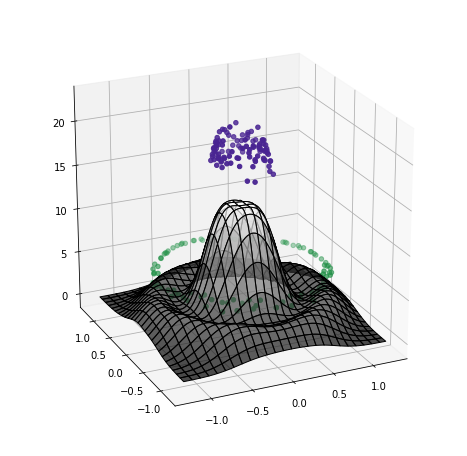

In [13]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(grid[0], grid[1], kde_wireframe, rstride=4, cstride=4, cmap='gray', edgecolor='k', alpha=0.7)
ax.scatter(noisy_circles[:,0], noisy_circles[:,1], local_models.utils.kernel_density(noisy_circles, noisy_circles, KERNEL(0.3)) + 0.2, c=cmap(c))

ax.view_init(22.987012987013202, -114.58064516129022)
plt.show()

In [14]:
noisy_circles.shape

(200, 2)

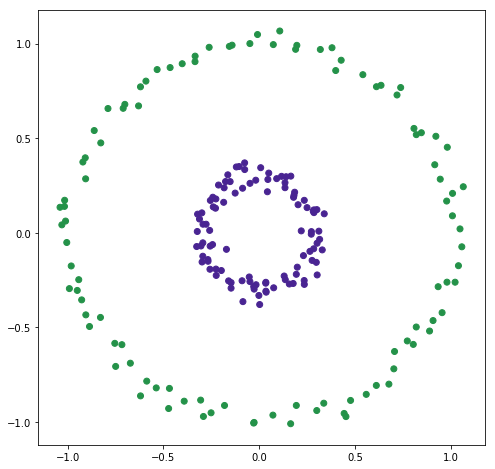

In [15]:
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
plt.show()

In [16]:
mean_models = local_models.local_models.LocalModels(local_models.TLS_models.Mean())
mean_models.fit(noisy_circles)
linear_models = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(1))
linear_models.fit(noisy_circles)

In [ ]:
BANDWIDTH = 0.192
N_STEPS = 300
ITERATIONS = 100
VIEWS = [(52.987012987013202, -114.58064516129022)]
fig_dir_kd_iterprojections = os.path.join(project_dir, "tlsline_kd_projections_iteration_b{:.4f}_g{:05d}".format(BANDWIDTH,N_STEPS))
make_tlsline_kd_iterprojections_animation_parallel(linear_models, noisy_circles, c, fig_dir_kd_iterprojections, BANDWIDTH, grid_steps=N_STEPS, kernel=KERNEL, iterations=ITERATIONS, views=VIEWS)